In [ ]:

!pip install torch torchvision albumentations

In [ ]:

!git clone https://github.com/aliabbasi2000/PIDNet.git
%cd /content/PIDNet/

In [3]:
%%capture
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip
!unzip Train.zip -d ./LoveDA
!unzip Val.zip -d ./LoveDA

In [ ]:
!wget --content-disposition "https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download"
!mv PIDNet_S_ImageNet.pth.tar /content/PIDNet/pretrained_models/imagenet

In [5]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import cv2

class LoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None):
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])

      # Load the image and mask
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      # Convert mask to tensor and shift labels
      mask = np.array(mask, dtype=np.int64) - 1  # Shift labels to range [0, 6]
      mask = np.clip(mask, 0, num_classes - 1)  # Ensure no negative values

      # Apply transformations if specified
      if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

      # Convert to PyTorch tensors
      image = image.clone().detach().float()  # HWC to CHW
      mask = mask.clone().detach().long()

      return image, mask


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
from torch.utils.data import DataLoader
from albumentations import Compose, HorizontalFlip, RandomRotate90, Resize, Normalize
from torchvision.transforms import ToTensor
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(512, 512),  # Resize both image and mask
    #####    AUGMENTATION HERE      #######
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define transforms for the evaluation phase

eval_transform = Compose([
    Resize(512, 512),  # Resize to match the input size of the model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define dataset paths
data_root = '/content/PIDNet/LoveDA'


# Load datasets
train_dataset = LoveDADataset(root=data_root, split='Train', region='Urban', transform=train_transform)
val_dataset = LoveDADataset(root=data_root, split='Val', region='Urban', transform=eval_transform)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)



In [7]:
import torch
from models.pidnet import get_seg_model
import yaml

## get_pred ------------------------------------
#model = get_pred_model('pidnet_s', num_classes=7)

## get_seg ------------------------------------
# Convert the dictionary to a DotDict
class DotDict(dict):
    """A dictionary that supports attribute-style access."""
    def __getattr__(self, name):
        value = self.get(name)
        if isinstance(value, dict):
            return DotDict(value)
        return value

    def __setattr__(self, name, value):
        self[name] = value

# Load the YAML configuration
with open('/content/PIDNet/configs/loveda/pidnet_small_loveda.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)

# Convert to DotDict for attribute-style access
cfg = DotDict(cfg_dict)

imgnet = 'imagenet' in cfg.MODEL.PRETRAINED

model = get_seg_model(cfg, imgnet_pretrained=imgnet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)




/content/PIDNet/models/pidnet.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


In [8]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=-1)

# Change the LR to 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [9]:
!pip install torchinfo

In [10]:
import torch.nn.functional as F
from torchinfo import summary
import time
import numpy as np

def calculate_iou(predictions, ground_truth, num_classes):
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

# Training
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
epoch_train_miou = []  # To store training mIoU per epoch
epoch_val_miou = []    # To store validation mIoU per epoch
epoch_train_loss = []  # To store training loss per epoch
epoch_val_loss = []    # To store validation loss per epoch

final_flops = 0.0
final_params = 0

for epoch in range(num_epochs):
    # Training phase
    train_loss = 0.0
    train_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        outputs = outputs[0]
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, num_classes)
        train_classwise_iou += np.nan_to_num(batch_iou)
        num_batches += 1

    train_loss /= len(train_loader)
    mean_classwise_iou = train_classwise_iou / num_batches
    train_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_train_miou.append(train_mean_iou)
    epoch_train_loss.append(train_loss)

    if epoch == num_epochs - 1:  # Save FLOPs, and Params only for the final epoch
        flops_summary = summary(model, input_size=(1, *images.shape[1:]), verbose=0)
        final_flops = flops_summary.total_mult_adds
        final_params = flops_summary.total_params

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training mIoU: {train_mean_iou:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs[0]
            masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, num_classes)
            val_classwise_iou += np.nan_to_num(batch_iou)
            num_batches += 1

    val_loss /= len(val_loader)
    mean_classwise_iou = val_classwise_iou / num_batches
    val_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_val_miou.append(val_mean_iou)
    epoch_val_loss.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation mIoU: {val_mean_iou:.4f}")

# Print final results
print(f"Final FLOPs: {final_flops:.2f}")
print(f"Final Params: {final_params}")

print("Class-wise IoU:")
for cls, label in enumerate(class_labels):
    print(f"  {label}: {mean_classwise_iou[cls]:.4f}")

Epoch 1/20, Training Loss: 2.4426, Training mIoU: 0.1915
Epoch 1/20, Validation Loss: 1.9163, Validation mIoU: 0.2470
Epoch 2/20, Training Loss: 1.0725, Training mIoU: 0.3058
Epoch 2/20, Validation Loss: 1.6612, Validation mIoU: 0.2903
Epoch 3/20, Training Loss: 0.9279, Training mIoU: 0.3460
Epoch 3/20, Validation Loss: 1.4601, Validation mIoU: 0.3168
Epoch 4/20, Training Loss: 0.8537, Training mIoU: 0.3801
Epoch 4/20, Validation Loss: 1.3776, Validation mIoU: 0.3330
Epoch 5/20, Training Loss: 0.8036, Training mIoU: 0.4101
Epoch 5/20, Validation Loss: 1.3769, Validation mIoU: 0.3462
Epoch 6/20, Training Loss: 0.7678, Training mIoU: 0.4278
Epoch 6/20, Validation Loss: 1.4034, Validation mIoU: 0.3586
Epoch 7/20, Training Loss: 0.7375, Training mIoU: 0.4469
Epoch 7/20, Validation Loss: 1.3704, Validation mIoU: 0.3697
Epoch 8/20, Training Loss: 0.7136, Training mIoU: 0.4564
Epoch 8/20, Validation Loss: 1.3257, Validation mIoU: 0.3945
Epoch 9/20, Training Loss: 0.6970, Training mIoU: 0.4670

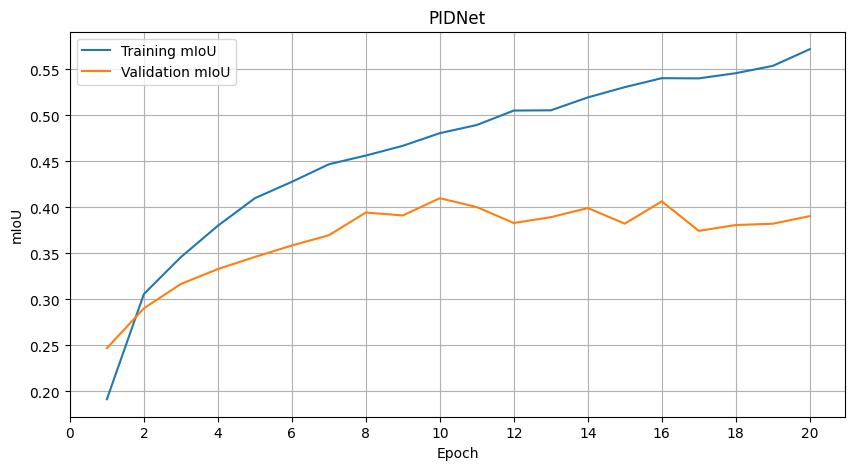

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_miou, label='Training mIoU')
plt.plot(range(1, num_epochs + 1), epoch_val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('PIDNet')
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

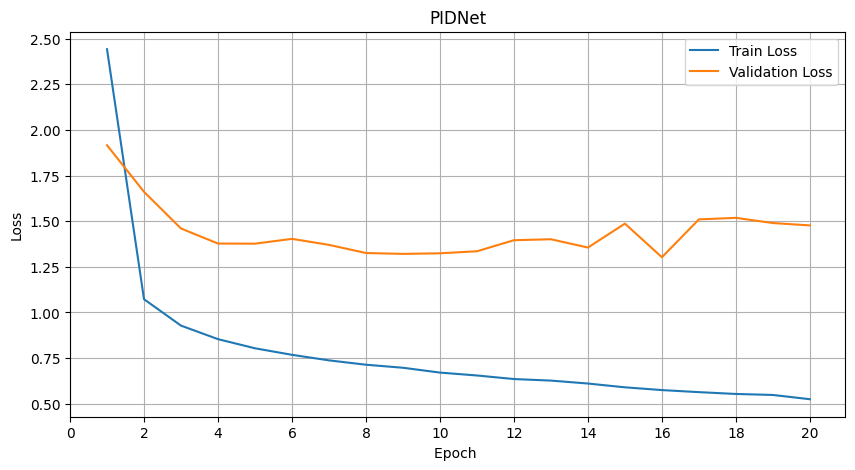

In [12]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), epoch_val_loss, label="Validation Loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.title("PIDNet")
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

In [13]:
!mkdir -p LoveDA/Test/Rural

Latency: 10.71 ms



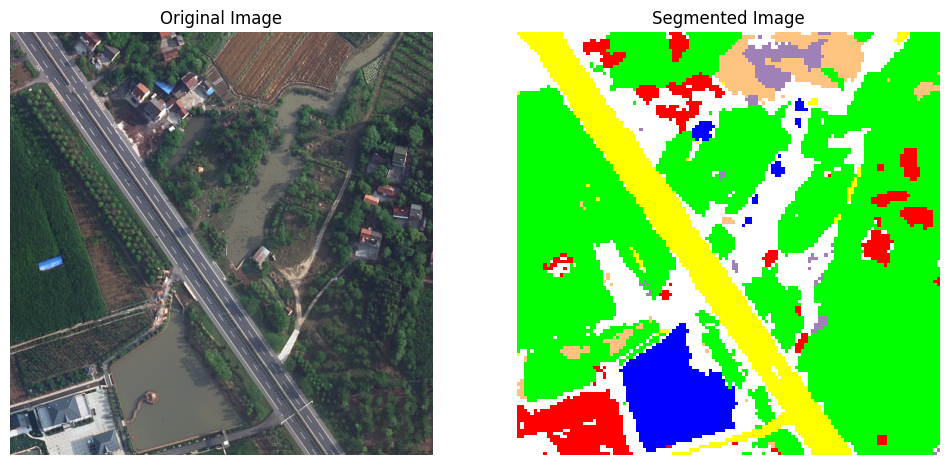

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (255, 255, 255),        # White
    "building": (255, 0, 0),             # Red
    "road": (255, 255, 0),               # Yellow
    "water": (0, 0, 255),                # Blue
    "barren": (159, 129, 183),           # Purple
    "forest": (0, 255, 0),               # Green
    "agriculture": (255, 195, 128)       # Peach
}

# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')



# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference with the model
model.eval()
with torch.no_grad():
    start_time = time.time()
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    end_time = time.time()
    latency = (end_time - start_time) * 1000  # Convert to milliseconds

    output = output[0]  # Remove auxiliary outputs if present
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

# Print the latency
print(f"Latency: {latency:.2f} ms")
print()

plt.show()




#Test3: Results with LR = 0.0001 with get_seg_model and no Augmentaton

Validation Loss: 1.3866, Validation mIoU: 0.
4003


#Test2: Results with LR = 0.001 with get_seg_model and no Augmentaton

Validation Loss: 1.7222, Validation mIoU: 0.
3525


#Test1: Results with LR = 0.001 & no augmentation & get_pred_model:

Validation Loss: 1.5764, Validation mIoU: 0.2721
